# Visualization of Targeted Chemical Cross-Linking Data

A supplement Notebook for producing plots related to **Identification of Protective Antibodies using _in silico_ Protein Docking coupled with Targeted Chemical Cross-Linking Mass Spectrometry** (unpublished manuscript).

---

## TOC

- [Notebook instructions](#notebook-instructions)
- [Packages](#packages)
  - [Descriptions](#descriptions)
  - [Imports](#imports)
- [Variables](#variables)
- [Functions](#functions)
- [Analysis](#analysis)
  - [Cross-linking summary](#cross-linking-summary)
  - [Structural analysis](#structural-analysis)

---

## Notebook instructions

There are two dropdown menus in this Notebook that allow for user input. [The first one](#subset-selection-receiver) sets the antigen of interest (for a cursory look), [while the second](#subset-selection-ligand) sets the antibody to perform further structural analysis on. If `run all` was executed initially, change the menu option and select `run below` from the subsequent code box.

## Packages

Below are short descriptions of the packages required to run this Notebook, presented in `import` order. All required packages are easily installed through the use of `conda` and the included environment.yml (for further detail check the project [GitHub-repo](https://github.com/COMPUTE-Jupyter-course/project-for-compute-jupyter-2022-jstrobaek)).

### Descriptions

#### pickle

Used to load a python variable, stored in `.pkl` format.

#### sqlite3

**Imported to alias `sql`.** For SQLite database querying of stored upstream data.

#### math

Used to round up to closest multiple of ten (using `ceil`).

#### pathlib

Utilized for assignment of I/O files and related path handling.

#### typing

Used for soft type-setting of functions.

#### matplotlib

**Imported to alias `plt`.** For creating a superimposed subplot, format axis decimal points, and setting the default format of the plots produced.

#### nglview

**Imported to alias `nv`.** Used to visualize molecular (here protein) structures in Jupyter Notebooks.

#### ipywidgets

**Imported to alias `widgets`.** Included for creation of dropdown menus.

#### pandas

**Imported to alias `pd`.** Utilized for data wrangling.

#### seaborn

**Imported to alias `sns`.** Used to create plots.

#### Bio

Short for `Biopython`, which is used for I/O operations with biological data (e.g. in `.pdb` or `.fasta` format) and generating parse-able python objects of imported data.

#### Ipython

Required for generating markdown rich-text from within a code block (with `Ipython.display.Markdown`).

### Imports

In [1]:
# Package imports:
import pickle
import sqlite3 as sql
from math import ceil
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets as widgets
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.PDB import PDBParser, PPBuilder, Selection, Structure
from IPython.display import Markdown
from ipywidgets import fixed, interact
from matplotlib.ticker import StrMethodFormatter
from matplotlib_inline import backend_inline
from pandas import DataFrame

# Set plot related global options.
backend_inline.set_matplotlib_formats('svg')  # Set plot format.
sns.set_theme(style="whitegrid")  # Set plot theme.

## Variables

To not crowd the notebook with uninteresting code, the below variable(s) are stored in `.pkl` files and imported at runtime. Pickle files are currently found in the [GitHub repo](https://github.com/COMPUTE-Jupyter-course/project-for-compute-jupyter-2022-jstrobaek), but will be moved to a corresponding Zenodo repo at a later date.

In [2]:
# Variable imports:
with open('vars/aa_3to1.pkl', 'rb') as f:

    aa_3to1 = pickle.load(f)

## Functions

Declaration of functions used within this Notebook. These would be moved to utility scripts if they were more extensive.

In [3]:
# Function definitions:
def sql_to_df(db_file: Path, query: str = 'SELECT * FROM MS2data') -> DataFrame:

    con = sql.connect(db_file)

    return pd.read_sql(query, con)

def eu_dist(structure: Structure, a: int, b: int) -> float:

    chain_1 = Selection.unfold_entities(structure, 'R')[a].get_parent().id

    chain_2 = Selection.unfold_entities(structure, 'R')[b].get_parent().id

    atom_1 = structure[0][chain_1][a]['CA']

    atom_2 = structure[0][chain_2][b]['CA']

    return atom_2 - atom_1

def locate_xls(structure: Structure,
               sequence_combined: str,
               xls: List[str], cutoff: int) -> List[List]:

    xl_atom_pairs = []

    for xl in xls:

        split_xl = xl.split('--')

        peptide_1 = split_xl[0].strip('-.()0123456789')

        k_pos_p1 = peptide_1.find('K') + 1

        peptide_2 = split_xl[1].strip('-.()0123456789')

        k_pos_p2 = peptide_2.find('K') + 1

        euclidean_distance = 10000

        tmp_distance = 10000

        mult_occ_p1 = [x for x in range(len(sequence_combined))
                       if sequence_combined.find(peptide_1, x) == x]

        mult_occ_p2 = [x for x in range(len(sequence_combined))
                       if sequence_combined.find(peptide_2, x) == x]

        seq_pos_p1_k = 0

        seq_pos_p2_k = 0

        for pos_1 in mult_occ_p1:

            for pos_2 in mult_occ_p2:

                a = pos_1 + k_pos_p1 + 1

                b = pos_2 + k_pos_p2 + 1

                if tmp_distance > eu_dist(structure, a, b):

                    tmp_distance = eu_dist(structure, a, b)

                    seq_pos_p1_k = pos_1 + k_pos_p1

                    seq_pos_p2_k = pos_2 + k_pos_p2

        if ((peptide_1 in sequence_combined) and
            (peptide_2 in sequence_combined)):

            a = seq_pos_p1_k + 1

            b = seq_pos_p2_k + 1

            euclidean_distance = eu_dist(structure, a, b)

        if euclidean_distance <= cutoff:

            xl_atom_pairs.append([str(seq_pos_p1_k - 1), str(seq_pos_p2_k - 1)])

    return xl_atom_pairs

## Analysis

### **( ! )** Subset selection: receiver

Select antigen (receiver) of interest in the below dropdown. To rerun the analysis with a different antigen select a new item in the dropdown, and rerun the cells below the input box.

In [4]:
# Display dropdown to enable data subset selection.
receivers = [p.name for p in Path('data').resolve().glob('*')]

receivers.sort()

receiver_subset = widgets.Dropdown(options=receivers,
                                   value=receivers[0],
                                   description='Receiver:', disabled=False)

display(receiver_subset)

Dropdown(description='Receiver:', options=('m1-b_rep', 'm1-c_rep'), value='m1-b_rep')

### Cross-linking summary

Load and summarize upstream data for the selected receiver (antigen). The produced barplot can be saved by hovering over the displayed figure and selecting the save icon (💾).

In [9]:
# Get ligand names from dir names.
receiver = receiver_subset.value

base_dir = Path(f'data/{receiver}').resolve()

if not base_dir.is_dir():

    text = f'The requested directory "{base_dir}" does not exist.'

    raise FileNotFoundError(text)

ligands = tuple((path.name for path in base_dir.iterdir()))

# Read upstream data (of all ligands) from SQLite database to a dataframe.
db_file = 'ms2_results.sql'  # Hardcoded database filename.

df = pd.concat({receiver:
                pd.concat({ligand:
                           sql_to_df(db_file=base_dir / ligand / db_file)
                           for ligand in ligands}, axis=0)}, axis=0)

# Create a new dataframe with counts (based on type) for each ligand.
theoretical_xls = {}

supported_xls = {}

counts = {'ligand': [], 'n_theoretical_xls': [], 'n_supported_xls': []}

for ligand in ligands:

    ms2_xls = df.loc[(receiver,), 'XL'][ligand].tolist()

    top_xls = !cat {base_dir / ligand / 'top_xls.txt'}

    theoretical_xls[ligand] = ms2_xls

    supported_xls[ligand] = top_xls

    counts['ligand'].append(ligand)

    counts['n_theoretical_xls'].append(len(ms2_xls))

    counts['n_supported_xls'].append(len(top_xls))

counts_df = pd.DataFrame.from_dict(counts)

counts_df.sort_values(by='n_theoretical_xls', ascending=False, inplace=True)

In [33]:
df

XL  \
m1-c_rep LUIGSeq_m11_ctrl-tail03_r0 0     -.AKLEEEK(2)--VTMSCKSSQSLLDSGNQK(6).-   
                                    1           -.LEEEKQISDASR(5)--KSGVPDR(1).-   
                                    2            -.LEEEKQISDASR(5)--LELKPK(4).-   
                                    3              -.LEEEKQISDASR(5)--VDKK(3).-   
                                    4              -.LEEEKQISDASR(5)--KIVP(1).-   
...                                                                         ...   
         LUIGSeq_m11_top03_r0       7   -.EEKQISDASR(3)--IVMTQTPKFLLVSAGDR(8).-   
                                    8           -.EEKQISDASR(3)--GKSTLTVDK(2).-   
                                    9                -.EEKQISDASR(3)--KIVP(1).-   
                                    10               -.ALEAKLEEEK(5)--KIVP(1).-   
                                    11               -.ALEAKLEEEK(5)--KIVP(1).-   

                                                                                 mgf_file  \
m1-c_rep LUIGSeq_m11_ctrl-tail03_r0 0   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    1   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    2   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    3   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    4   /srv/data1/home/jo0348st/projects/2023-heusel_...   
...                                                                                   ...   
         LUIGSeq_m11_top03_r0       7   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    8   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    9   /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    10  /srv/data1/home/jo0348st/projects/2023-heusel_...   
                                    11  /srv/data1/home/jo0348st/projects/2023-heusel_...   

                                                                           spectrum_id  \
m1-c_rep LUIGSeq_m11_ctrl-tail03_r0 0   controllerType=0 controllerNumber=1 scan=42817   
                                    1   controllerType=0 controllerNumber=1 scan=23250   
                                    2   controllerType=0 controllerNumber=1 scan=10648   
                                    3   controllerType=0 controllerNumber=1 scan=13662   
                                    4    controllerType=0 controllerNumber=1 scan=5523   
...                                                                                ...   
         LUIGSeq_m11_top03_r0       7   controllerType=0 controllerNumber=1 scan=44027   
                                    8   controllerType=0 controllerNumber=1 scan=10720   
                                    9   controllerType=0 controllerNumber=1 scan=19020   
                                    10  controllerType=0 controllerNumber=1 scan=13719   
                                    11  controllerType=0 controllerNumber=1 scan=24736   

                                        spectrum_num  delta  pre_charge  \
m1-c_rep LUIGSeq_m11_ctrl-tail03_r0 0              6   0.01           4   
                                    1            592   0.01           4   
                                    2            703   0.01           5   
                                    3            772   0.01           4   
                                    4            832   0.01           5   
...                                              ...    ...         ...   
         LUIGSeq_m11_top03_r0       7           1686   0.01           5   
                                    8           1771   0.01           5   
                                    9           1877   0.01           3   
                                    10          2274   0.01           4   
                                    11          2280   0.

In [32]:
counts_df

,ligand,n_theoretical_xls,n_supported_xls
3,LUIGSeq_m11_ctrl-tail01_r0,39,5
2,LUIGSeq_m11_ctrl-tail02_r0,32,4
0,LUIGSeq_m11_ctrl-tail03_r0,31,3
5,LUIGSeq_m11_ctrl-igs01_r0,31,2
4,LUIGSeq_m11_top05_r0,26,3
7,LUIGSeq_m11_ctrl-pls01_r0,25,3
6,LUIGSeq_m11_top01_r0,20,1
8,LUIGSeq_m11_top02_r0,20,1
1,LUIGSeq_m11_top04_r0,14,1
9,LUIGSeq_m11_top03_r0,12,1


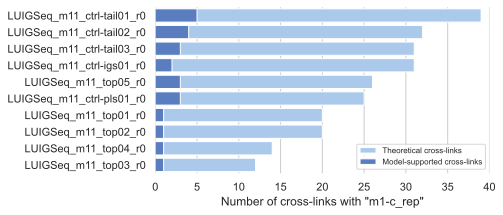

In [10]:
# Plot the count data.
f, ax = plt.subplots(figsize=(6, 3))

sns.set_color_codes("pastel")

sns.barplot(x="n_theoretical_xls", y="ligand", data=counts_df,
            label="Theoretical cross-links", color="b")

sns.set_color_codes("muted")

sns.barplot(x="n_supported_xls", y="ligand", data=counts_df,
            label="Model-supported cross-links", color="b")

rounded_max = ceil(counts_df.iloc[:, 1].values.max()/10)*10

ax.legend(ncol=1, loc="lower right", frameon=True, fontsize=8)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set(xlim=(0, rounded_max),
       ylabel='', xlabel=f'Number of cross-links with "{receiver}"')

sns.despine(left=True, bottom=True)

The above plot compares the number of cross-links observed in the mass spectrometry data to the number of cross-links supported by the predicted protein docking model.

### **( ! )** Subset selection: ligand

Select antibody Fab (ligand) of interest in the below dropdown. To rerun the analysis with a different Fab select a new item in the dropdown, and rerun the cells below the input box.

In [11]:
# Display dropdown to enable data subset selection.
top_ligand = counts_df.loc[counts_df['n_theoretical_xls'].idxmax()]['ligand']
ligand_subset = widgets.Dropdown(options=ligands,
                               value=top_ligand,
                               description='Ligand:',
                               disabled=False)
display(ligand_subset)

Dropdown(description='Ligand:', index=3, options=('LUIGSeq_m11_ctrl-tail03_r0', 'LUIGSeq_m11_top04_r0', 'LUIGS…

### Structural analysis

... of the selected ligand (antibody).

In [12]:
ligand = ligand_subset.value

tmp_pdb = base_dir / ligand / 'best_model.pdb'

parser = PDBParser()

tmp_structure = parser.get_structure(f'{receiver}--{ligand}', tmp_pdb)

tmp_model = tmp_structure[0]

polypeptides = []

for record in SeqIO.parse(base_dir / ligand / 'input.fasta', 'fasta'):

    polypeptides.append(str(record.seq))

sequence = ''

for chain in tmp_model:

    seq = []

    for res in chain:

        seq.append(aa_3to1[res.resname])

    sequence += ''.join(seq)

search_sequence = str(sequence)

sequence_combined = str(sequence)

pp_indexes = []

for pp in polypeptides:

    while search_sequence.find(pp) > -1:

        idx_start = search_sequence.find(pp)

        idx_full = [idx_start + 1, idx_start + len(pp)]

        search_sequence = search_sequence.replace(pp, '-' * len(pp), 1)

        pp_indexes.append((idx_full, pp))

pp_indexes.sort()

In [14]:
# Generate sequence markdown table.
cells = '\n'.join([f'{pp[0][0]} | {pp[0][1]} | {pp[1]}' for pp in pp_indexes])

label = '**Table 1.** Sequence indices.'

headers = 'Start | Stop | Sequence'

justification = ':-: | :-: | :-'

md_table = !echo -e '{label}\n{headers}\n{justification}\n{cells}'

Markdown('\n'.join(md_table))

**Table 1.** Sequence indices.
Start | Stop | Sequence
:-: | :-: | :-
1 | 120 | AKLEEEKQISDASRQSLRRDLDASREAKKQVEKDLANLTAELDKVKEDKQISDASRQGLRRDLDASREAKKQVEKDLANLTAELDKVKEEKQISDASRQGLRRDLDASREAKKQVEKALE
121 | 240 | AKLEEEKQISDASRQSLRRDLDASREAKKQVEKDLANLTAELDKVKEDKQISDASRQGLRRDLDASREAKKQVEKDLANLTAELDKVKEEKQISDASRQGLRRDLDASREAKKQVEKALE
241 | 452 | DIVMTQSPSSLSVSAGEKVTMSCKSSQSLLDSGNQKKYLAWYQQKPGHPPKLLIYGASTRKSGVPDRFTGSGSGTDFTLTISGVQAEDLAIYYCQNDHSYPLTFGAGTKLELKPKSSPSVTLFPPSSEELETNKATLVCTITDFYPGVVTVDWKVDGTPVTQGMETTQPSKQSNNKYMASSYLTLTARAWERHSSYSCQVTHEGHTVEKSLS
453 | 668 | QVQLQQSGPELVKPGASVKISCKASGFSFTSYYIHWVKQRPGQGLEWIGWIYLGSGNTKYNEKFKGKATLTADTSSSTAFMQLSSLTSEDSAVYYCASPSGWAWFAYWGQGTLVTVSAKTTPPSVYPLAPGSAAQTNSMVTLGCLVKGYFPEPVTVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVPSSTWPSETVTCNVAHPASSTKVDKKIVP

In [27]:
structure = parser.get_structure(ligand, tmp_pdb)

cutoff = 30

top_xls_idx = locate_xls(structure, sequence_combined, top_xls, cutoff)

ms2_xls_idx = locate_xls(structure, sequence_combined, ms2_xls, cutoff)

In [28]:
pdb = base_dir / ligand / 'best_model_corr.pdb'

abc = 'ABCDEFG'

assigned_chains = []

pdb_edit = base_dir / ligand / 'edit.pdb'

pdb_edit.touch()

for i, index in enumerate(pp_indexes):

    idx = f'-{index[0][0]}:{index[0][1]}'

    chain = f'-{abc[i]}'

    assigned_chains.append(abc[i])

    !pdb_selres {idx} {tmp_pdb} | pdb_chain {chain} >> {pdb_edit}

!pdb_tidy {pdb_edit} | pdb_reatom > {pdb}

pdb_edit.unlink()

In [29]:
view_structure = parser.get_structure(ligand, pdb)

representations = ["Backbone", "Cartoon"]

XLs = ['Show', 'Hide']

colors = {'A': '#595959', 'B': '#595969', 'C': '#360568', 'D': '#b79ced'}

view = nv.show_biopython(view_structure[0], default_representation=False)

view.background = 'lightgray'

def change_representation(view, Representation, XLs):

    view.clear()

    for chain in assigned_chains:

        view.add_representation(Representation,
                                selection=f':{chain}', color=colors[chain])

    if XLs in 'Show':

        for xl in ms2_xls_idx:

            view.add_distance(atom_pair=[xl], color='#323031',
                              label_color='black', label_size=5)

        for xl in top_xls_idx:

            view.add_distance(atom_pair=[xl],
                              color='#f26419',
                              label_color='black', label_size=5)

view.center()

interact(change_representation,
         view=fixed(view),
         Representation=representations, XLs=XLs)
view

interactive(children=(Dropdown(description='Representation', options=('Backbone', 'Cartoon'), value='Backbone'…

NGLWidget(background='lightgray')

The above representation shows the **antibody Fab (purple)** docked to the **antigen (gray)**. Cross-links can be toggled to show where those within the given cutoff (30 Ångström) could theoretically be observed (black), and where they were observed in the mass spectrometry data (orange). Floating numbers are euclidean distances, in Ångström, between the alpha-carbons of the cross-linked lysines.

In [ ]:
# TODO:
# - Add button to save the current state (coordinates) of the above structure
#   - Could be used with other packages to generate stylized figures
#   - Save coordinates to disk

Below are code cells with unused but useful code.

In [ ]:
# ligand_ms2_xls = df.loc[(receiver, ligand), 'XL']

# ligand_model_xls = df.loc[(receiver, ligand),
#                           :].query(f'XL in {top_xls}').loc[:, 'XL']